In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import wave
import sounddevice as sd
from scipy.io import wavfile
from scipy.interpolate import interp1d
import pandas as pd

# An arbitrary sample rate, as its value doesn't really matter when written as headerless raw data or for plotting
fs = 48000

# Audio output volume when auditioning
volume = 0.05

# Required wavecycle length (4096 is what the Udo Super 6 expects)
nsamps = 4096

### Plotting

def compare(oscs, ncycles=1, filterAtHz=None, playSoundAtHz=None, env=None):
    """
    Plot waveforms and their spectrogram for harmonic analysis

    Args:
        oscs: array of waveform generator function names
        ncycles: number of wavecycles to plot
        filterAtHz (optional): low-pass butterworth cutoff frequency
        playSoundAtHz (optional): frequency of sample tones to play of the given waveforms
        env (optional [attack, decay, sustain, release]): ADSR amplitude envelope

    """
    plot_wavecycle(oscs, filterAtHz, ncycles)
    plot_spectrum(oscs, filterAtHz)
    if playSoundAtHz: play_sound(oscs, playSoundAtHz, filterAtHz, env)

def plot_wavecycle(oscs, filterAtHz, ncycles):
    """
    Plot waveform generator function wavecycles

    Args:
        oscs: array of waveform generator function names
        filfilterAtHz (optional): low-pass butterworth cutoff frequency
        ncycles: number of wavecycles to plot
    """
    # determine the frequency for which one wavecycle spans the required number of samples
    f = fs/nsamps
    plt.figure(figsize=(12,4))
    for osc in oscs:
        x, data = osc(f, ncycles)
        if filterAtHz: data = filter(data, filterAtHz)
        plt.plot(x, normalize(data))
    plt.title('Wavecycle')
    plt.show()

def filter(data, cut=512.0, order=4):
    """
    Apply a low-pass Butterworth filter to an array of samples

    Args:
        data: sample data to be filtered
        cut: cutoff frequency
        order: filter order (higher is steeper)
    """
    if cut == None: return data
    nyq = 0.5 * fs
    normal_cutoff = cut / nyq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return signal.lfilter(b, a, data)

def normalize(data):
    """
    Normalize an array of samples to the range [-1,1]
    """
    data = np.copy(data) # signal is in range [a;b]
    data -= np.min(data) # signal is in range to [0;b-a]
    data /= np.max(data) # signal is normalized to [0;1]
    data -= 0.5 # signal is in range [-0.5;0.5]
    data *=2 # signal is in range [-1;1]
    return data

def plot_spectrum(oscs, filterAtHz):
    """
    Plot waveform generator function spectrograms for harmonic analysis

    Args:
        oscs: Array of waveform generator functions
        filterAtHz (optional): filter cutoff frequency to apply to the waveforms
    """
    plt.figure(figsize=(10,4))
    for osc in oscs:
        _, data = osc(1000, 1000)
        if filterAtHz: data = filter(data, filterAtHz)
        f, psd = signal.welch(data, fs, nperseg=256)
        # normalize peaks to same y value for easier visual comparison of relative harmonic strength
        peak = np.max(psd)
        norm = psd / peak
        plt.plot(f, norm)
    plt.title('Power Spectral Density')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD (dB/Hz)')
    plt.yscale('log')
    plt.xlim(0, 20000)
    plt.xticks(np.arange(0, 20000, step=1000), [])

def play_sound(oscs, f, filterAtHz, env):
    """
    Play tones for an array of waveform generator functions in sequence, optionally filtered and/or with an amplitude envelope so it's easier to estimate what it may sound like on the destination synth.
    """
    for osc in oscs:
        _, data = osc(f, f) # play for one second (one second is when the number of cycles == f)
        if filterAtHz: data = filter(data, filterAtHz, 4)
        if env: data = adsr(volume*data.astype(np.float32), env)
        sd.play(data, samplerate=fs, blocking=True)

def adsr(signal, env):
    """
    Apply ADSR envelope to a signal where A, D, and R are proportions (0-1) of the total signal length.
    
    Args:
    - signal: The audio signal to apply the envelope to
    - attack: Proportion of signal length for attack stage (0-1)
    - decay: Proportion of signal length for decay stage (0-1)
    - sustain: Amplitude level during sustain stage (0-1)
    - release: Proportion of signal length for release stage (0-1)
    
    Returns:
    - Signal with applied envelope
    """
    [attack, decay, sustain, release] = env

    n = len(signal)
    
    # Validate input parameters
    if attack + decay + release > 1:
        print("Warning: Sum of attack, decay, and release exceeds 1. Normalizing to fit signal length.")
        total = attack + decay + release
        attack /= total
        decay /= total
        release /= total
    
    # Convert proportions to sample counts
    attack_samples = int(attack * n)
    decay_samples = int(decay * n)
    release_samples = int(release * n)
    
    # Calculate sustain samples (remaining samples after A, D, R are allocated)
    sustain_samples = n - attack_samples - decay_samples - release_samples
    
    # Create envelope
    envelope = np.zeros(n)
    
    # Keep track of the current position in the envelope
    current_pos = 0
    
    # Attack (linear ramp from 0 to 1)
    if attack_samples > 0:
        envelope[current_pos:current_pos+attack_samples] = np.linspace(0, 1, attack_samples)
        current_pos += attack_samples
    
    # Decay (exponential decay from 1 to sustain)
    if decay_samples > 0:
        decay_curve = np.linspace(0, 1, decay_samples)
        # Using a curve for more natural sounding decay
        decay_curve = 1 - (1 - sustain) * (decay_curve**0.5)  
        envelope[current_pos:current_pos+decay_samples] = decay_curve
        current_pos += decay_samples
    
    # Sustain (constant at sustain)
    if sustain_samples > 0:
        envelope[current_pos:current_pos+sustain_samples] = sustain
        current_pos += sustain_samples
    
    # Release (exponential decay from sustain to 0)
    if release_samples > 0:
        release_curve = np.linspace(0, 1, release_samples)
        # Using squared curve for more natural sounding release
        release_curve = sustain * (1 - release_curve**2)  
        envelope[current_pos:current_pos+release_samples] = release_curve
    
    # Apply envelope to signal
    return signal * envelope

### Saving

def save(osc, f, ncycles, name, filterAtHz=None):
    """
    Create sample data given a waveform generator function and save it as an Udo Super 6 wavecycle

    e.g. `save(sawtri2(0.01, 0.9), fs/nsamps, 1, "sawtribytes")`

    Args:
        osc: a waveform generator function
        f: frequency
        ncycles: number of wavecycles to repeat (duration)
        name: name of the file to be saved
        filterAtHz (optional): cutoff frequency of the low-pass filtered output
    """
    _, data = osc(f, ncycles)
    if filterAtHz: data = filter(data, filterAtHz)
    data = np.int16(normalize(data) * 32767)
    write_ws6(data, name)

def write_ws6(data, name):
    """
    Save sample data as a named Udo Super 6 wavecycle format: 16-bit signed integer, normalized, single-cycle waveform with nsamps points, optionally bandlimited at 512Hz, binary file containing no header data and file extension .ws6
    """
    with open(f"./{name}.ws6", "wb") as w:
        w.write(bytearray(data))
    
def ws6_to_wav(data, name):
    """
    Save an Udo Super 6 waveform file as wav
    """
    with wave.open(f"./{name}.ws6", "w") as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2) # 16-bit
        wf.setframerate(fs)
        wf.writeframes(data.tobytes())

#### Waveform generator functions
def sin(f, ncycles):
    """
    Waveform generator function for a sine wave.
    
    Args:
    - mod_params: List of tuples (modRatio, amount) for each operator
                 Each tuple defines a modulator's frequency ratio and intensity
    
    Returns:
    - A function that takes carrier frequency and number of cycles and returns the FM signal
    """
    x = xs(f, ncycles)
    return x, np.sin(2 * np.pi * f * x)

def saw(f, ncycles):
    """
    Waveform generator function for a sawtooth wave
    
    Args:
        f: Frequency
        ncycles: Number of wavecycles to repeat
    
    Returns:
        A tuple: time domain, sample values
    """
    x = xs(f, ncycles)
    return x, signal.sawtooth(2*np.pi*f*x)

def tri(f, ncycles):
    """
    Waveform generator function for a triangle wave
    
    Args:
        f: Frequency
        ncycles: Number of wavecycles to repeat
    
    Returns:
        A tuple: time domain, sample values
    """
    x = xs(f, ncycles)
    return x, signal.sawtooth(2*np.pi*f*x, 0.5)

def sqr(duty=0.5):
    """
    Waveform generator function for a square wave
    
    Args:
        duty: The wavecycle duty (pulse width)
    
    Returns:
        Function (waveform generator function):
            Args:
                f: Frequency
                ncycles: Number of wavecycles to repeat
            
            Returns:
                A tuple: time domain, sample values
    """
    def inner(f, ncycles):
        x = xs(f, ncycles)
        return x, signal.square(2*np.pi*f*x, duty)
    return inner

def sawsqr(mix=0.5, phase=np.pi, duty=0.5):
    """
    Waveform generator function for a sawtooth+square wave
    
    Args:
        mix (float 0-1): The balance between the saw and square where 0=only saw and 1=only square
        phase: Phase offset of the square wave
        duty: The wavecycle duty (pulse width)
    
    Returns:
        Function (waveform generator function):
        
            Args:
                f: Frequency
                ncycles: Number of wavecycles to repeat
            
            Returns:
                A tuple: time domain, sample values
    """
    def inner(f, ncycles):
        x = xs(f, ncycles)
        return x, ((1.0-mix)*signal.sawtooth(2*np.pi*f*x) + mix*signal.square(2*np.pi*f*x + phase, duty))
    return inner

def sawtri(mix=0.5, p1=1, p2=0.5):
    """
    Waveform generator function for a sawtooth+triangle wave
    
    Args:
        mix (float between [0,1]): The balance between the saw and triangle where 0=only saw and 1=only triangle
        p1: width of the first waveform
        p2: width of the second waveform
    
    Returns:
        Function (waveform generator function):
            Args:
                f: Frequency
                ncycles: Number of wavecycles to repeat
            
            Returns:
                A tuple: time domain, sample values
    """
    def inner(f, ncycles):
        x = xs(f, ncycles)
        return x, ((1.0-mix)*signal.sawtooth(2*np.pi*f*x, p1) + mix*signal.sawtooth(2*np.pi*f*x, p2))
    return inner

def fm_multi(mod_params):
    """
    Create a waveform generator function for multi-operator FM synthesis.
    
    Args:
        mod_params: List of tuples (modRatio, amount) for each operator, where each tuple defines a modulator's frequency ratio and intensity
    
    Returns:
        Function (waveform generator function):
        
            Args:
                f: Frequency (carrier)
                ncycles: Number of wavecycles to repeat
            
            Returns:
                A tuple: time domain, sample values
    """
    def inner(fCarrier, ncycles):
        x = xs(fCarrier, ncycles)
        
        # Start with no modulation
        modulation = 0
        
        # Apply each modulator in sequence (from last to first)
        for modRatio, amount in reversed(mod_params):
            fModulator = modRatio * fCarrier
            modulator_signal = np.sin(2 * np.pi * fModulator * x + modulation)
            modulation = amount * modulator_signal
        
        # Final carrier with accumulated modulation
        return x, np.sin(2 * np.pi * fCarrier * x + modulation)
    
    return inner

def fm_parallel(mod_params):
    """
    Create a waveform generator function for multi-operator FM synthesis with parallel modulators.
    All modulators affect the carrier directly, not in a chain.
    
    Args:
        mod_params: List of tuples (modRatio, amount) for each operator
    
    Returns:
        Function (waveform generator function):
        
            Args:
                f: Frequency (carrier)
                ncycles: Number of wavecycles to repeat
            
            Returns:
                A tuple: time domain, sample values
    """
    def inner(fCarrier, ncycles):
        x = xs(fCarrier, ncycles)
        
        # Calculate total modulation from all modulators
        total_modulation = 0
        for modRatio, amount in mod_params:
            fModulator = modRatio * fCarrier
            modulator = np.sin(2 * np.pi * fModulator * x)
            total_modulation += amount * modulator
        
        # Apply the total modulation to the carrier
        return x, np.sin(2 * np.pi * fCarrier * x + total_modulation)
    
    return inner

def xs(f, ncycles):
    """
    Generate the time domain for plotting (x-axis)

    Args:
        f: Frequency
        ncycles: Number of wavecycles to repeat
    
    Returns:
        Numpy array of the time domain in terms of seconds
    """
    n = int(fs/f)*ncycles
    secs = n/fs
    return np.linspace(0, secs, n)

### Operations on Waveform Generator Functions
def mult(osc1, osc2):
    """
    Multiply two waveform generator functions
    
    Returns:
        Function (waveform generator function):
            Args:
                f: Frequency
                ncycles: Number of wavecycles to repeat
            
            Returns:
                A tuple: time domain, sample values
    """
    def inner(f, ncycles):
        x, y1 = osc1(f, ncycles)
        _, y2 = osc2(f, ncycles)
        return x, y1*y2
    return inner

def add(osc1, osc2):
    """
    Add two waveform generator functions
    
    Returns:
        Function (waveform generator function):
            Args:
                f: Frequency
                ncycles: Number of wavecycles to repeat
            
            Returns:
                A tuple: time domain, sample values
    """
    def inner(f, ncycles):
        x, y1 = osc1(f, ncycles)
        _, y2 = osc2(f, ncycles)
        return x, y1+y2
    return inner

### Audio file interpolation
def interpolated(path, kind="cubic"):
    """
    Interpolate an audio file to meet the target number of samples.
    This should already have been trimmed to constitute one complete wave cycle.
    This lets us shrink or stretch a wavecyle to meet the number of cycles that a synthesizer requires without changing the fundamental frequency or perceived pitch.
    
    Returns:
        Function (waveform generator function):
            Args:
                f: Frequency
                ncycles: Number of wavecycles to repeat
            
            Returns:
                A tuple: time domain, sample values
    """
    def inner(f, ncycles):
        data = np.tile(interpolate(read(path), int(fs/f), kind), ncycles)
        x = xs(f, ncycles)
        return x, data
    return inner

def as_loudness_contour(path, cutoff=None, applyHanningWindow=True):
    """
    Transform a WAV file into its loudness contour (e.g. to be used as an LFO). Filter for smoothness. Apply hanning window to ensure the start and end approaches the same sample value.
    
    Returns:
        Function (waveform generator function):
            Args:
                f: Frequency
                ncycles: Number of wavecycles to repeat
            
            Returns:
                A tuple: time domain, sample values
    """
    def inner(f, ncycles):
        data = np.tile(interpolate(filter(loudness_contour(path), cutoff, 4), int(fs/f)), ncycles)
        if applyHanningWindow: data *= np.hanning(len(data))
        x = xs(f, ncycles)
        return x, data
    return inner

def read(path):
    """
    Reads a WAV file and returns the data as a Numpy float array.

    Args:
        path (str): The path to the WAV file.

    Returns:
        tuple: A tuple containing the sample rate (int) and the data as a float array.
               Returns None if an error occurs during file reading.
    """
    try:
        _, data = wavfile.read(path)
    except Exception as e:
        print(f"Error reading WAV file: {e}")
        return None

    # Convert data to float32, if it isn't already
    if data.dtype != np.float32: data = data.astype(np.float32)

    # Normalize data to the range [-1, 1]
    max_value = np.max(np.abs(data))
    if max_value > 0: data = data / max_value
    
    # Convert to mono
    if data.ndim == 2: data = [l for [l, r] in data]

    return data

def as_is(path):
    """
    A plottable audio file without interpolation.
    
    Returns:
        Function (waveform generator function):
            Args:
                f: Frequency
                ncycles: Number of wavecycles to repeat
            
            Returns:
                A tuple: time domain, sample values
    """
    def inner(f, ncycles):
        data = read(path)
        x = xs(f, ncycles)
        return x, data
    return inner

def interpolate(samples, target_length, kind="cubic"):
    """
    Interpolate (shrink or stretch) audio samples to meet a target length.
    
    Args:
        samples: List or array of audio samples (float32)
        target_length: Desired length of the output
        
    Returns:
        Numpy array of interpolated samples with length target_length
    """
    # Convert to numpy array if it's a list
    if isinstance(samples, list): samples = np.array(samples, dtype=np.float32)
    
    # Create the original x-coordinates (sample positions)
    x_original = np.linspace(0, 1, len(samples))
    
    # Create the target x-coordinates
    x_target = np.linspace(0, 1, target_length)
    
    # Create interpolation function (cubic spline)
    f = interp1d(
        x_original, 
        samples, 
        kind=kind,
        bounds_error=False,  # Don't raise error for out-of-bounds
        fill_value="extrapolate"  # Extrapolate if needed
    )
    
    # Apply the interpolation function to get new samples
    return f(x_target).astype(np.float32)

def loudness_contour(path):
    """
    Analyzes a WAV file and returns a list of floats representing its loudness contour.

    Args:
        path (str): The path to the WAV file.

    Returns:
        list: A list of floats, where each float represents the root mean square (RMS)
              of a frame of audio data.  A larger value indicates greater loudness.
    """

    try:
        with wave.open(path, 'rb') as wf:
            # Read file parameters
            sample_width = wf.getsampwidth()
            frame_rate = wf.getframerate()
            n_frames = wf.getnframes()

            # Read audio data
            raw_data = wf.readframes(n_frames)

            # Convert to NumPy array
            audio_data = np.frombuffer(raw_data, dtype=f'int{sample_width*8}')
            
            # Calculate RMS loudness for each frame
            frame_size = int(frame_rate * 0.02)  # 20ms frame size (common)
            loudness_contour = []
            
            for i in range(0, len(audio_data), frame_size):
                frame_data = audio_data[i:i + frame_size]
                loudness_contour.append(np.sqrt(np.mean(np.square(frame_data))))
            
            # replace nans with interpolated values (forward then backward fill)
            loudness_contour = pd.Series(loudness_contour)
            loudness_contour = loudness_contour.fillna(method='ffill').fillna(method='bfill')

            return loudness_contour
            
    except wave.Error as e:
        print(f"Error processing WAV file: {e}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

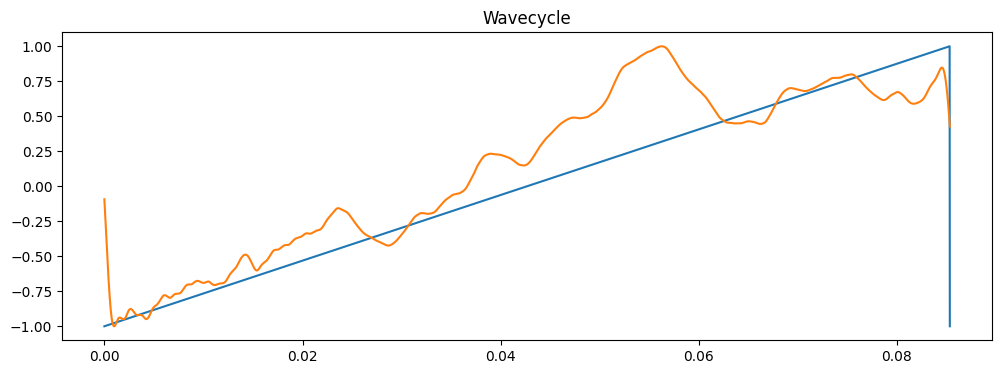

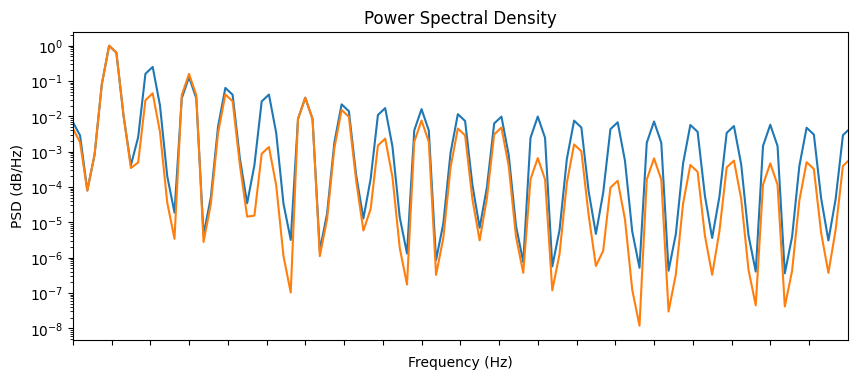

In [62]:
compare([saw, interpolated("./examples/ProphetRev2_MajicalHornz.wav")])
save(interpolated("./examples/ProphetRev2_MajicalHornz.wav"), fs/nsamps, 1, "./examples/ProphetRev2_MajicalHornz")